![title](pend.png)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import ray
import ray.rllib.agents.ppo as ppo
import ray.rllib.agents.ddpg as ddpg
import seagul.envs
import numpy as np
from numpy import pi
import gym

/home/sgillen/miniconda3/envs/ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sgillen/miniconda3/envs/ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sgillen/miniconda3/envs/ray/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sgillen/miniconda3/envs/ray/lib/python3.6/s

In [24]:
home_path = '/home/sgillen/work/'
checkpoint_path = home_path + \
"seagul/seagul/notebooks/sym_rl/data/pendulum3/PPO/PPO_sym_pendulum-v0_0_sgd_minibatch_size=64_2019-11-18_11-24-08ks8gn2nm/checkpoint_150/checkpoint-150"

In [26]:
# Some delightfully ugly python to infer where everything else is...
csv_path = '/'.join(checkpoint_path.split('/')[:-2]) + '/progress.csv'
save_name = checkpoint_path.split('/')[-3]
expr_file = "/experiment_state-" + save_name[-27:-8] + ".json"
expr_path = '/'.join(checkpoint_path.split('/')[:-3]) + expr_file

expr_data = json.load(open(expr_path))
config = expr_data['checkpoints'][-1]['config']
env_name = config['env']


df = pd.read_csv(csv_path)
#df

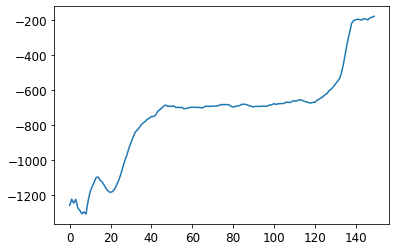

In [27]:
plt.plot(df['episode_reward_mean'])

In [28]:
ray.shutdown()
ray.init()

trainer = ppo.PPOTrainer(config)#, config['env_name'])
#trainer = ddpg.DDPGTrainer(config)
trainer.restore(checkpoint_path)

2019-11-21 11:38:48,307	INFO resource_spec.py:205 -- Starting Ray with 5.32 GiB memory available for workers and up to 2.68 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2019-11-21 11:38:48,683	INFO trainer.py:344 -- Tip: set 'eager': true or the --eager flag to enable TensorFlow eager execution
/home/sgillen/miniconda3/envs/ray/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
2019-11-21 11:38:50,511	INFO rollout_worker.py:768 -- Built policy map: {'default_policy': <ray.rllib.policy.tf_policy_template.PPOTFPolicy object at 0x7f79df6c94e0>}
2019-11-21 11:38:50,512	INFO rollout_worker.py:769 -- Built preprocessor map: {'default_policy': <ray.rllib.models.preprocessors.NoPreprocessor object at 0x7f79df6c9198>}


-1739.483117856758


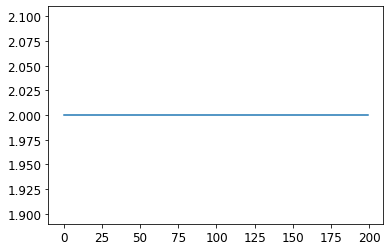

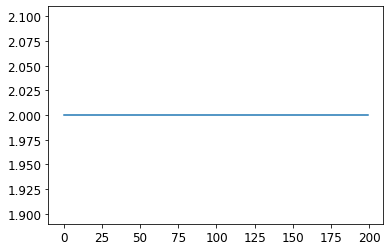

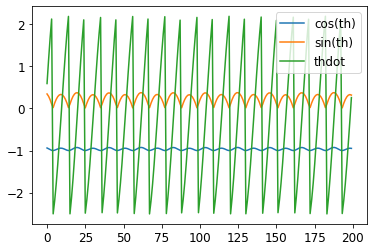

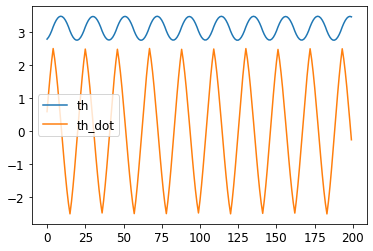

In [29]:
import gym
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

env = gym.make(env_name)
obs = env.reset()

action_hist = []
m_act_hist = []
state_hist  = []
obs_hist = []
reward_hist = []

done = False
while not done:
    #actions = trainer.compute_action(obs.flatten())
    actions = np.array([2])
    obs, reward, done, _ = env.step(np.asarray(actions))
    #env.render()
    action_hist.append(np.copy(np.clip(actions, -2, 2)))
    m_act_hist.append(np.copy(action_hist[-1]*np.sign(obs[1])))
    
    state_hist.append(np.copy(env.state))
    obs_hist.append(np.copy(obs))
    reward_hist.append(np.copy(reward))
    if done:
        break


print(sum(reward_hist))
plt.plot(action_hist)
plt.figure()
plt.plot(m_act_hist)
plt.figure()
plt.plot(obs_hist)
plt.legend(['cos(th)', 'sin(th)', 'thdot'])
plt.figure()
plt.plot(state_hist)
plt.legend(['th', 'th_dot'])


In [30]:
# Reminder that the bahavior logits that come out are the mean and logstd (not log mean, despite the name logit)
trainer.compute_action(obs, full_fetch=True)

(array([2.], dtype=float32),
 [],
 {'action_prob': 0.21409252,
  'action_logp': -1.541347,
  'vf_preds': -127.71454,
  'behaviour_logits': array([2.0280778 , 0.53976583], dtype=float32)})

In [33]:
th_vals = np.linspace(-2*pi, 2*pi, 100)
thdot_vals= np.linspace(-8, 8, 100)
actions = np.zeros((th_vals.size, thdot_vals.size))
mirr_space = np.zeros((th_vals.size, thdot_vals.size))

vf_preds = np.zeros((th_vals.size, thdot_vals.size))
act_probs = np.zeros((th_vals.size, thdot_vals.size))
act_means = np.zeros((th_vals.size, thdot_vals.size))
act_lgstd = np.zeros((th_vals.size, thdot_vals.size))

for th_i, th in enumerate(th_vals):
    for thdot_i, thdot in enumerate(thdot_vals):
        env.env.state = [th , thdot]
        obs = env.env._get_obs()
        
        #obs = np.array([np.cos(th), np.sin(th), thdot])
        actions[th_i, thdot_i],_, out_dict = trainer.compute_action(obs.flatten(),full_fetch=True)
        mirr_space[th_i, thdot_i] = np.sign(obs[1])
        vf_preds[th_i,  thdot_i]  = out_dict['vf_preds']
        act_probs[th_i, thdot_i]  = out_dict['action_prob']
        act_means[th_i, thdot_i]  = out_dict['behaviour_logits'][0]
        act_lgstd[th_i, thdot_i]  = out_dict['behaviour_logits'][1]
        

In [34]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 18
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

x,y = np.meshgrid(th_vals, thdot_vals, indexing='ij')

Text(0.5, 1.0, 'Sampled Actions')

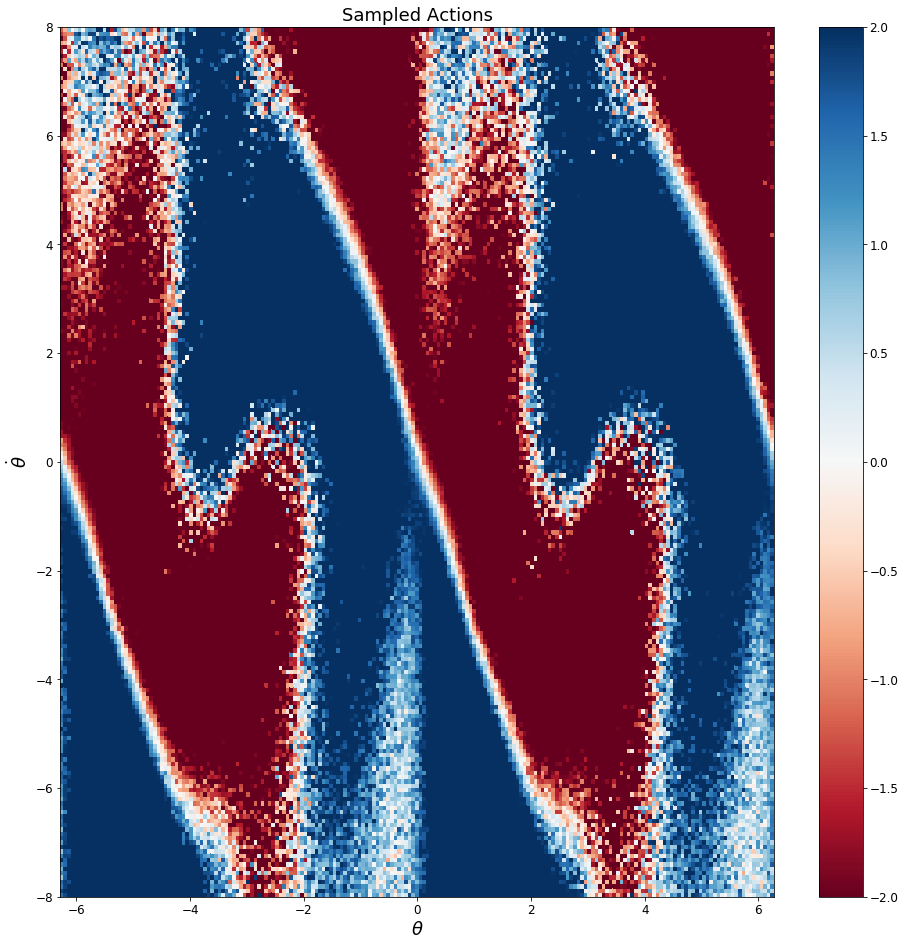

In [19]:
z = actions
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('Sampled Actions')

Text(0.5, 1.0, 'Action Means')

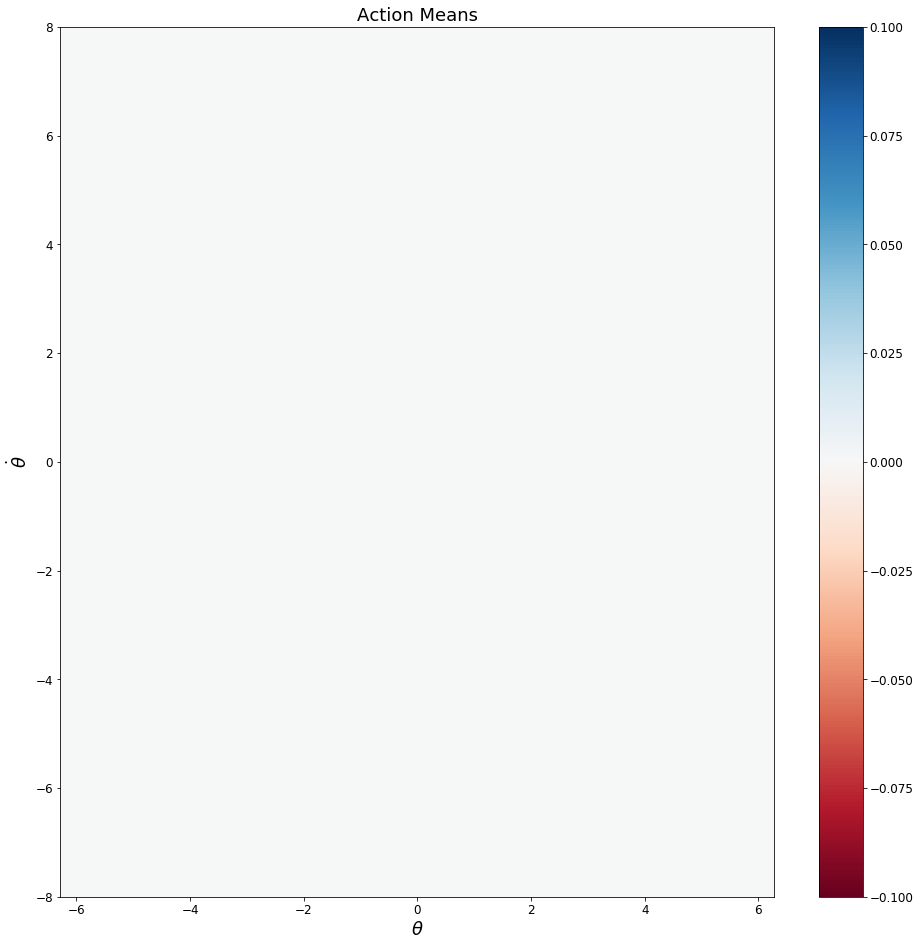

In [21]:
z = act_means
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('Action Means')

In [ ]:
z = np.exp(act_lgstd)
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('Action Stds')

In [ ]:
z = vf_preds
z = z[:-1, :-1]
z_min, z_max = z.min(), z.max()


fig, ax = plt.subplots(1,1, figsize=(16,16))
c = ax.pcolormesh(x, y, z, cmap='RdBu', vmin=z_min, vmax=z_max)
ax.axis([x.min(), x.max(), y.min(), y.max()])
fig.colorbar(c, ax=ax)

   
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\dot \theta$')
plt.title('VF Prediction')